In [1]:
from pyspark.sql import SparkSession
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
import geopandas as gpd

spark = SparkSession. \
    builder. \
    appName('Airline Search'). \
    master('spark://DESKTOP-RV59F4C.localdomain:7077'). \
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config('spark.jars.packages',
           'org.apache.sedona:sedona-python-adapter-3.0_2.12:1.0.1-incubating,'
           'org.datasyslab:geotools-wrapper:geotools-24.1'). \
    getOrCreate()

SedonaRegistrator.registerAll(spark)

21/12/08 15:22:10 WARN Utils: Your hostname, DESKTOP-RV59F4C resolves to a loopback address: 127.0.1.1; using 192.168.20.1 instead (on interface eth0)
21/12/08 15:22:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
:: loading settings :: url = jar:file:/root/spark-3.0.3-bin-hadoop3.2/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.apache.sedona#sedona-python-adapter-3.0_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5c5d7c55-033e-4b9a-8bf5-5b3fa6e6a63f;1.0
	confs: [default]
	found org.apache.sedona#sedona-python-adapter-3.0_2.12;1.0.1-incubating in central
	found org.locationtech.jts#jts-core;1.18.0 in central
	found org.wololo#jts2geojson;0.16.1 in central
	found com.fasterxml.jackson.core#jackson-databind;2.12.2 in central
	found com.fasterxml.j

True

## Load state boundries in WKT TSV

In [3]:
import os.path
if os.path.isfile("./boundary-each-state.tsv"):
    print("boundary-each-state.tsv exists")
else:
    !wget https://raw.githubusercontent.com/DataOceanLab/CPTS-415-Project-Examples/main/boundary-each-state.tsv

boundary-each-state.tsv exists


## Convert WKT string column to a geometry column

In [62]:
states_wkt = spark.read.option("delimiter", "\t").option("header", "false").csv("boundary-each-state.tsv").toDF("s_name","s_bound")
states_wkt.show()
states_wkt.printSchema()

states = states_wkt.selectExpr("s_name", "ST_GeomFromWKT(s_bound) as s_bound")
states.show()
states.printSchema()
states.createOrReplaceTempView("states")

+-------------+--------------------+
|       s_name|             s_bound|
+-------------+--------------------+
|       Alaska|POLYGON((-141.020...|
|      Alabama|POLYGON((-88.1955...|
|     Arkansas|POLYGON((-94.0416...|
|      Arizona|POLYGON((-112.598...|
|   California|POLYGON((-124.400...|
|     Colorado|POLYGON((-109.044...|
|  Connecticut|POLYGON((-73.4875...|
|     Delaware|POLYGON((-75.7919...|
|      Florida|POLYGON((-87.6050...|
|      Georgia|POLYGON((-85.6082...|
|       Hawaii|POLYGON((-154.628...|
|         Iowa|POLYGON((-95.7623...|
|        Idaho|POLYGON((-117.031...|
|     Illinois|POLYGON((-90.6290...|
|      Indiana|POLYGON((-87.5253...|
|       Kansas|POLYGON((-102.050...|
|     Kentucky|POLYGON((-89.5372...|
|    Louisiana|POLYGON((-94.0430...|
|Massachusetts|POLYGON((-72.7789...|
|     Maryland|POLYGON((-79.4778...|
+-------------+--------------------+
only showing top 20 rows

root
 |-- s_name: string (nullable = true)
 |-- s_bound: string (nullable = true)



+-------------+--------------------+
|       s_name|             s_bound|
+-------------+--------------------+
|       Alaska|POLYGON ((-141.02...|
|      Alabama|POLYGON ((-88.195...|
|     Arkansas|POLYGON ((-94.041...|
|      Arizona|POLYGON ((-112.59...|
|   California|POLYGON ((-124.40...|
|     Colorado|POLYGON ((-109.04...|
|  Connecticut|POLYGON ((-73.487...|
|     Delaware|POLYGON ((-75.791...|
|      Florida|POLYGON ((-87.605...|
|      Georgia|POLYGON ((-85.608...|
|       Hawaii|POLYGON ((-154.62...|
|         Iowa|POLYGON ((-95.762...|
|        Idaho|POLYGON ((-117.03...|
|     Illinois|POLYGON ((-90.629...|
|      Indiana|POLYGON ((-87.525...|
|       Kansas|POLYGON ((-102.05...|
|     Kentucky|POLYGON ((-89.537...|
|    Louisiana|POLYGON ((-94.043...|
|Massachusetts|POLYGON ((-72.778...|
|     Maryland|POLYGON ((-79.477...|
+-------------+--------------------+
only showing top 20 rows

root
 |-- s_name: string (nullable = true)
 |-- s_bound: geometry (nullable = false)



## Importing airports.dat and perform data cleaning

In [4]:
if os.path.isfile("./airports.dat"):
    print("airports.dat exits")
else:
    !wget https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat

airports.dat exits


In [5]:
# Import data to Spark data frame
airport_dat = spark.read.option("delimiter", ",").option("header", "false").csv("airports.dat").toDF("AirportID","Name"
,"City","Country","IATA","ICAO","Latitude","Longitude","Altitude","Timezone","DST","Database Time Zone","Type","Source")

# Make all Null values have the same representation
airport_dat = airport_dat.fillna('N/A')
airport_dat = airport_dat.na.replace("\\N","N/A")
airport_dat = airport_dat.na.replace("-","N/A")

# Choose only necessary attributes

# Combine Longitude and Latitude into one collumn
from pyspark.sql import functions
airport = airport_dat.select("AirportID", "Name", "City", "Country","IATA","ICAO",
                                 functions.concat_ws("_",airport_dat.Longitude,airport_dat.Latitude).alias("Location"))

# Convert string to geometry type
airport = airport.selectExpr("*", "ST_PointFromText(Location, \'_\') as geospacial_Location")
airport = airport.drop("Location")
airport.createOrReplaceTempView("airport")
airport.show()
airport.printSchema()

+---------+--------------------+--------------+----------------+----+----+--------------------+
|AirportID|                Name|          City|         Country|IATA|ICAO| geospacial_Location|
+---------+--------------------+--------------+----------------+----+----+--------------------+
|        1|      Goroka Airport|        Goroka|Papua New Guinea| GKA|AYGA|POINT (145.391998...|
|        2|      Madang Airport|        Madang|Papua New Guinea| MAG|AYMD|POINT (145.789001...|
|        3|Mount Hagen Kagam...|   Mount Hagen|Papua New Guinea| HGU|AYMH|POINT (144.296005...|
|        4|      Nadzab Airport|        Nadzab|Papua New Guinea| LAE|AYNZ|POINT (146.725977...|
|        5|Port Moresby Jack...|  Port Moresby|Papua New Guinea| POM|AYPY|POINT (147.220001...|
|        6|Wewak Internation...|         Wewak|Papua New Guinea| WWK|AYWK|POINT (143.669006...|
|        7|  Narsarsuaq Airport|  Narssarssuaq|       Greenland| UAK|BGBW|POINT (-45.425998...|
|        8|Godthaab / Nuuk A...|      Go

## Importing airline.dat and perform data cleaning

In [6]:
if os.path.isfile("./airlines.dat"):
    print("airlines.dat exits")
else:
    !wget https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat

airlines.dat exits


In [7]:
# Import data to Spark data frame
airline_dat = spark.read.option("delimiter", ",").option("header", "false").csv("airlines.dat").toDF("AirlineID","Name"
,"Alias","IATA","ICAO","Callsign","Country","Active")

# Make all Null values have the same representation
airline_dat = airline_dat.fillna('N/A')
airline_dat = airline_dat.na.replace("\\N","N/A")
airline_dat = airline_dat.na.replace("-","N/A")

# Drop unused attributes
airline_dat = airline_dat.drop("Callsign")

airline_dat.createOrReplaceTempView("airline")

# Drop non-sense tuples
airline_dat = spark.sql("select * from airline where AirlineID > 0")

airline_dat.show()
airline_dat.printSchema()
airline = airline_dat

+---------+--------------------+-----+----+----+--------------+------+
|AirlineID|                Name|Alias|IATA|ICAO|       Country|Active|
+---------+--------------------+-----+----+----+--------------+------+
|        1|      Private flight|  N/A| N/A| N/A|           N/A|     Y|
|        2|         135 Airways|  N/A| N/A| GNL| United States|     N|
|        3|       1Time Airline|  N/A|  1T| RNX|  South Africa|     Y|
|        4|2 Sqn No 1 Elemen...|  N/A| N/A| WYT|United Kingdom|     N|
|        5|     213 Flight Unit|  N/A| N/A| TFU|        Russia|     N|
|        6|223 Flight Unit S...|  N/A| N/A| CHD|        Russia|     N|
|        7|   224th Flight Unit|  N/A| N/A| TTF|        Russia|     N|
|        8|         247 Jet Ltd|  N/A| N/A| TWF|United Kingdom|     N|
|        9|         3D Aviation|  N/A| N/A| SEC| United States|     N|
|       10|         40-Mile Air|  N/A|  Q5| MLA| United States|     Y|
|       11|              4D Air|  N/A| N/A| QRT|      Thailand|     N|
|     

## Importing routes.dat

In [8]:
if os.path.isfile("./routes.dat"):
    print("routes.dat exits")
else:
    !wget https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat

routes.dat exits


In [9]:
# Import data to Spark data frame
route_dat = spark.read.option("delimiter", ",").option("header", "false").csv("routes.dat").toDF("Airline","AirlineID"
,"SourceAirport","SourceAirportID","DestinationAirport","DestinationAirportID","Codeshare","Stops","Equipment")

# Drop unused attributes
route_dat = route_dat.drop("Equipment")

# Make all Null values have the same representation
route_dat = route_dat.fillna('N/A')
route_dat = route_dat.na.replace("\\N","N/A")
route_dat = route_dat.na.replace("-","N/A")

route = route_dat
route.createOrReplaceTempView("route")

route.show()

+-------+---------+-------------+---------------+------------------+--------------------+---------+-----+
|Airline|AirlineID|SourceAirport|SourceAirportID|DestinationAirport|DestinationAirportID|Codeshare|Stops|
+-------+---------+-------------+---------------+------------------+--------------------+---------+-----+
|     2B|      410|          AER|           2965|               KZN|                2990|      N/A|    0|
|     2B|      410|          ASF|           2966|               KZN|                2990|      N/A|    0|
|     2B|      410|          ASF|           2966|               MRV|                2962|      N/A|    0|
|     2B|      410|          CEK|           2968|               KZN|                2990|      N/A|    0|
|     2B|      410|          CEK|           2968|               OVB|                4078|      N/A|    0|
|     2B|      410|          DME|           4029|               KZN|                2990|      N/A|    0|
|     2B|      410|          DME|           40

## Updating routes table

In [12]:
# The main logic here is to look up airport and airline tables

# Then update either airlineID or airportID, which ever is missing

# The method performed is a left join

### Updating airlineID using airline.IATA

In [13]:
airline_cp = spark.sql("Select * from airline where airline.IATA != 'N/A'")
airline_cp = airline_cp.withColumnRenamed("IATA","Airline")

In [14]:
route_cp = route.alias('r').join(airline_cp.alias('a'), on = 'Airline', how = 'left')\
    .select('r.Airline', functions.when(~functions.isnull(functions.col('a.AirlineID')),
                                       functions.col('a.AirlineID')
                                       ).otherwise(functions.col('r.AirlineID')).alias('AirlineID'),
           'r.SourceAirport', 'r.SourceAirportID', 'r.DestinationAirport', 'r.DestinationAirportID',
           'r.Codeshare', 'r.Stops').dropDuplicates()

### Updating airlineID using airline.ICAO

In [15]:
airline_cp = spark.sql("Select * from airline where airline.ICAO != 'N/A'")
airline_cp = airline_cp.withColumnRenamed("ICAO","Airline")

In [16]:
route_cp = route_cp.alias('r').join(airline_cp.alias('a'), on = 'Airline', how = 'left')\
    .select('r.Airline', functions.when(~functions.isnull(functions.col('a.AirlineID')),
                                       functions.col('a.AirlineID')
                                       ).otherwise(functions.col('r.AirlineID')).alias('AirlineID'),
           'r.SourceAirport', 'r.SourceAirportID', 'r.DestinationAirport', 'r.DestinationAirportID',
           'r.Codeshare', 'r.Stops').dropDuplicates()

### Updating SourceAirportID using airport.IATA

In [17]:
airport_cp = spark.sql("Select * from airport where airport.IATA != 'N/A'")
airport_cp = airport_cp.withColumnRenamed("IATA","SourceAirport")

In [18]:
route_cp = route_cp.alias('r').join(airport_cp.alias('a'), on = 'SourceAirport', how = 'left')\
    .select('r.Airline', 'r.AirlineID','r.SourceAirport', functions.when(~functions.isnull(functions.col('a.AirportID')),
                                       functions.col('a.AirportID')
                                       ).otherwise(functions.col('r.SourceAirportID')).alias('SourceAirportID'), 
            'r.DestinationAirport', 'r.DestinationAirportID',
           'r.Codeshare', 'r.Stops').dropDuplicates()

### Updating SourceAirportID using airport.ICAO

In [19]:
airport_cp = spark.sql("Select * from airport where airport.ICAO != 'N/A'")
airport_cp = airport_cp.withColumnRenamed("ICAO","SourceAirport")

In [20]:
route_cp = route_cp.alias('r').join(airport_cp.alias('a'), on = 'SourceAirport', how = 'left')\
    .select('r.Airline', 'r.AirlineID','r.SourceAirport', functions.when(~functions.isnull(functions.col('a.AirportID')),
                                       functions.col('a.AirportID')
                                       ).otherwise(functions.col('r.SourceAirportID')).alias('SourceAirportID'), 
            'r.DestinationAirport', 'r.DestinationAirportID',
           'r.Codeshare', 'r.Stops').dropDuplicates()

### Updating DestinationAirportID using airport.IATA

In [21]:
airport_cp = spark.sql("Select * from airport where airport.IATA != 'N/A'")
airport_cp = airport_cp.withColumnRenamed("IATA","DestinationAirport")

In [22]:
route_cp = route_cp.alias('r').join(airport_cp.alias('a'), on = 'DestinationAirport', how = 'left')\
    .select('r.Airline', 'r.AirlineID','r.SourceAirport', 'r.SourceAirportID',
            'r.DestinationAirport', functions.when(~functions.isnull(functions.col('a.AirportID')),
                                       functions.col('a.AirportID')
                                       ).otherwise(functions.col('r.DestinationAirportID')).alias('DestinationAirportID'),
           'r.Codeshare', 'r.Stops').dropDuplicates()

### Updating SourceAirportID using airport.ICAO

In [23]:
airport_cp = spark.sql("Select * from airport where airport.ICAO != 'N/A'")
airport_cp = airport_cp.withColumnRenamed("ICAO","DestinationAirport")

In [24]:
route_cp = route_cp.alias('r').join(airport_cp.alias('a'), on = 'DestinationAirport', how = 'left')\
    .select('r.Airline', 'r.AirlineID','r.SourceAirport', 'r.SourceAirportID',
            'r.DestinationAirport', functions.when(~functions.isnull(functions.col('a.AirportID')),
                                       functions.col('a.AirportID')
                                       ).otherwise(functions.col('r.DestinationAirportID')).alias('DestinationAirportID'),
           'r.Codeshare', 'r.Stops').dropDuplicates().sort("Airline")

In [27]:
# Take very long. Dont run this

route_cp.show()

+-------+---------+-------------+---------------+------------------+--------------------+---------+-----+
|Airline|AirlineID|SourceAirport|SourceAirportID|DestinationAirport|DestinationAirportID|Codeshare|Stops|
+-------+---------+-------------+---------------+------------------+--------------------+---------+-----+
|     2B|      410|          NUX|           4364|               SVX|                2975|      N/A|    0|
|     2B|      410|          ASF|           2966|               MRV|                2962|      N/A|    0|
|     2B|      410|          KZN|           2990|               CEK|                2968|      N/A|    0|
|     2B|      410|          LED|           2948|               UUA|                6160|      N/A|    0|
|     2B|      410|          KZN|           2990|               AER|                2965|      N/A|    0|
|     2B|      410|          UUA|           6160|               LED|                2948|      N/A|    0|
|     2B|      410|          LED|           29

## Find the list of airports operating in country X

In [29]:
# SQL query WHERE country == X

In [28]:
airport_cp = spark.sql("Select AirportID, Name, City, Country from airport")
X = input("Enter country's name: ")
airport_cp.filter(airport_cp.Country.rlike(f"(?i)^*{X}$")).show()

Enter country's name: Vietnam


+---------+--------------------+----------------+-------+
|AirportID|                Name|            City|Country|
+---------+--------------------+----------------+-------+
|     3196|Da Nang Internati...|          Danang|Vietnam|
|     3197|    Gia Lam Air Base|           Hanoi|Vietnam|
|     3198|        Kep Air Base|             Kep|Vietnam|
|     3199|Noi Bai Internati...|           Hanoi|Vietnam|
|     3200|  Nha Trang Air Base|        Nhatrang|Vietnam|
|     3201|     Phu Bai Airport|             Hue|Vietnam|
|     3204|Phu Quoc Internat...|         Phuquoc|Vietnam|
|     3205|Tan Son Nhat Inte...|Ho Chi Minh City|Vietnam|
|     4153| Lien Khuong Airport|           Dalat|Vietnam|
|     4154|    Dong Hoi Airport|        Dong Hoi|Vietnam|
|     4155|    Rach Gia Airport|        Rach Gia|Vietnam|
|     4156|      Cà Mau Airport|          Ca Mau|Vietnam|
|     4157|Chu Lai Internati...|         Chu Lai|Vietnam|
|     4158|    Dong Tac Airport|         Tuy Hoa|Vietnam|
|     6187|Buo

## Find the list of airlines having X stops

In [30]:
# Attribute Stops belongs to route table

# Airline Name belongs to airline table

# Both tables have attribute AirlineID

# Perform a inner join on AirlineID

In [31]:
# PySpark functionalities are used instead of SQL syntax

# But the result stays the same

from pyspark.sql.functions import when
route_cp.createOrReplaceTempView("route_cp")

# Take in user's input
X = input("Enter # stops: ")

# Select only airlines that have X stops from route table
newRoute = spark.sql(f"Select AirlineID, Stops from route_cp where route_cp.Stops == {X}")

# Select only used attributes from airline table
airline_cp = spark.sql(f"Select AirlineID, Name, Alias from airline")

# Inner join on AirlineID
newRoute = newRoute.alias('r').join(airline_cp.alias('a'), on = 'AirlineID', how = 'inner')\
    .select('r.AirlineID', when(airline_cp.Name != 'N/A', airline_cp.Name)
            .otherwise("a.Alias").alias('Airline_Name'),
'r.Stops').dropDuplicates()

# Show result
newRoute.filter(newRoute.Airline_Name != 'N/A').show()

Enter # stops: 1


+---------+--------------------+-----+
|AirlineID|        Airline_Name|Stops|
+---------+--------------------+-----+
|     1316|     AirTran Airways|    1|
|     1936|  Cubana de Aviación|    1|
|     4319|Scandinavian Airl...|    1|
|     1623|      Canadian North|    1|
|      330|          Air Canada|    1|
|     4547|  Southwest Airlines|    1|
+---------+--------------------+-----+



## List of airlines operating with codeshares

In [32]:
# Codeshare belongs to route table

# AirlineName belongs to airline table

# Again an inner join on AirlineID where Codeshare == Y or Codeshare == y

In [33]:
# Select used attributes from route table where Codeshare == Y | y
newRoute = spark.sql(f"Select AirlineID, Codeshare from route_cp where route_cp.Codeshare == 'Y' \
                     or route_cp.Codeshare == 'y'")

# Select only used attributes from airline table
airline_cp = spark.sql(f"Select AirlineID, Name, Alias from airline")

# Perform an inner join on AirlineID
airline_cp = newRoute.alias('r').join(airline_cp.alias('a'), on = 'AirlineID', how = 'inner')\
    .select('r.AirlineID', when(airline_cp.Name != 'N/A', airline_cp.Name)
            .otherwise("a.Alias").alias('Airline_Name'),
'r.Codeshare').dropDuplicates()

# Show result
airline_cp.filter(airline_cp.Airline_Name != 'N/A').show()

+---------+--------------------+---------+
|AirlineID|        Airline_Name|Codeshare|
+---------+--------------------+---------+
|     5179|               Tarom|        Y|
|      502|Abu Dhabi Amiri F...|        Y|
|      324|  All Nippon Airways|        Y|
|     2855|              Indigo|        Y|
|     5416|             WestJet|        Y|
|     5347|Virgin Atlantic A...|        Y|
|     1889|       Copa Airlines|        Y|
|     2421|               Flybe|        Y|
|     4559|Swiss Internation...|        Y|
|       28|     Asiana Airlines|        Y|
|     5309|    Vietnam Airlines|        Y|
|     1942|      Cyprus Airways|        Y|
|      137|          Air France|        Y|
|      241|          Air Sahara|        Y|
|     3378|   Malaysia Airlines|        Y|
|     1908|          Corsairfly|        Y|
|     1317|         Air Transat|        Y|
|     4292|    Rwandair Express|        Y|
|      197| Azerbaijan Airlines|        Y|
|     2056|           Dragonair|        Y|
+---------+

## Find the list of active airlines in the United States - Airline aggregation 

In [34]:
# SQL syntax for airline table

# WHERE country == US and active == Y | y
airline_cp = spark.sql("""
                       Select AirlineID, Name, Alias, Country, Active 
                       from airline 
                       where Country == 'United States' and (Active == 'Y' or Active == 'y')
                       """)
airline_cp = airline_cp.select(airline_cp.AirlineID, when(airline_cp.Name != 'N/A', airline_cp.Name)
            .otherwise(airline_cp.Alias).alias('Airline_Name'), airline_cp.Country, airline_cp.Active)

# Show result
airline_cp.filter(airline_cp.Airline_Name != 'N/A').show()

+---------+--------------------+-------------+------+
|AirlineID|        Airline_Name|      Country|Active|
+---------+--------------------+-------------+------+
|       10|         40-Mile Air|United States|     Y|
|       22|      Aloha Airlines|United States|     Y|
|       24|   American Airlines|United States|     Y|
|       35|       Allegiant Air|United States|     Y|
|      109|Alaska Central Ex...|United States|     Y|
|      149|  Air Cargo Carriers|United States|     Y|
|      210|Airlift Internati...|United States|     Y|
|      281|America West Airl...|United States|     Y|
|      282|       Air Wisconsin|United States|     Y|
|      287|Allegheny Commute...|United States|     Y|
|      295|        Air Sunshine|United States|     Y|
|      315|        ATA Airlines|United States|     Y|
|      397|           Arrow Air|United States|     Y|
|      452|Atlantic Southeas...|United States|     Y|
|      659|American Eagle Ai...|United States|     Y|
|      792|          Access 

## Find the country (or) territory has the highest number of Airports 

In [35]:
# The main logic is

# Filter out rows in which country is NULL

# Perform a group by on Country attribute

# Orient the result with a descending order

In [36]:
airport_cp = spark.sql("""
                select Country, count(Country) as Num_Airports
                from airport
                where country != 'N/A'
                group by Country
                order by Num_Airports desc
            """)

# Show result - only the first one is required
airport_cp.first()

Row(Country='United States', Num_Airports=1512)

## Top K cities with most incoming airlines - takes lots of time

In [ ]:
# Most incoming airlines == most DestinationAirport from route table

# Need to display AirportName, which belongs to airport table

# Perform an inner join on AirportID

In [41]:
# Take lots of time - don't run this

# Take users' input
K = input("How many cities: ")

# Choose used attributes from route table
airline_cp = spark.sql("""
                       Select AirlineID, DestinationAirportID 
                       from route_cp 
                       where AirlineID != 'N/A' and DestinationAirportID != 'N/A'
                       """)
airline_cp.createOrReplaceTempView("airline_cp")

# Choose used attributes from airport table
airport_cp = spark.sql("""
                       Select AirportID, City
                       from airport 
                       where City != 'N/A'
                       """)
airport_cp.createOrReplaceTempView("airport_cp")

# Inner join
result = spark.sql("""
            Select airport_cp.City, count(distinct airline_cp.AirlineID) as Num_Airlines
            from airline_cp
            inner join airport_cp
            on airline_cp.DestinationAirportID == airport_cp.AirportID
            group by airport_cp.City
            order by Num_Airlines desc
    """)

topIncomingAirport = result.limit(int(K))

#Show result
result.show(n = int(K))

How many cities: 8


+---------+------------+
|     City|Num_Airlines|
+---------+------------+
|    Paris|         147|
|   London|         139|
|   Moscow|         132|
|  Bangkok|         126|
|Frankfurt|         111|
|     Rome|         103|
| Istanbul|          99|
|    Dubai|          97|
|Hong Kong|          97|
|Singapore|          94|
|Amsterdam|          93|
|   Munich|          93|
|  Beijing|          91|
| New York|          86|
|   Milano|          85|
|Barcelona|          85|
|   Vienna|          83|
|   Zurich|          83|
| Shanghai|          82|
|    Tokyo|          82|
+---------+------------+
only showing top 20 rows



### Category graph - top K incoming airports

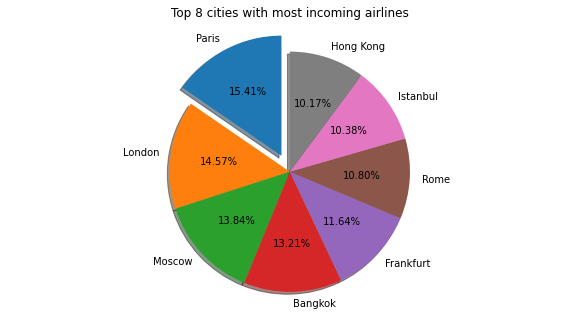

In [44]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery-nogrid')

keyList = [x['City'] for x in topIncomingAirport.collect()]
valueList = [x['Num_Airlines'] for x in topIncomingAirport.collect()]
labels = keyList
sizes = valueList

explode = [0.15]

for i in range (1, int(K)):
    explode.append(0)

explode = tuple(explode)

plt.rcParams['figure.figsize']=[8,4]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%0.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title(f'Top {K} cities with most incoming airlines')

plt.show()

### Bar graph - top K incoming airports

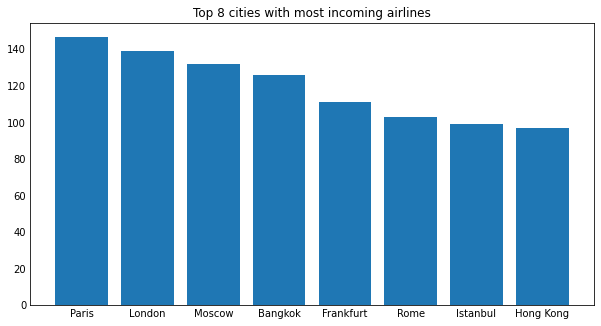

In [46]:
x = keyList
y = valueList
plt.bar(x,y)
plt.title(f'Top {K} cities with most incoming airlines')
plt.show()

## Find the closest airport to a city X’s geospatial coordinate 

In [37]:
# Example: Seattle

# Longitude = -122.313323

# Latitude = 47.622715

In [55]:
# Take users' inputs
X = input("Enter city's longitude: ")
Y = input("Enter city's latitude: ")

# Select used attributes from airport table
airport_cp = spark.sql("""
    select AirportID,Name,City,Country,geospacial_Location
    from airport
    where City != 'N/A'
""")
airport_cp.createOrReplaceTempView("airport_cp")

# Using Apache Sedona to turn X, Y into a point (ST_Point())

# Then using ST_Distance() to find out the closest airport
result = spark.sql(f" \
    SELECT a.AirportID, a.Name, a.City, a.Country, a.geospacial_Location, \
           ST_Distance(a.geospacial_Location, ST_Point({X}, {Y})) as Distance \
    FROM airport as a \
    ORDER by Distance")

closestAirport = result.limit(10)
closestAirport2 = gpd.GeoDataFrame(result.limit(100).toPandas(), geometry = "geospacial_Location")

# Show result
result.show()

Enter city's longitude: -122.313323
Enter city's latitude: 47.622715


+---------+--------------------+--------------+-------------+--------------------+-------------------+
|AirportID|                Name|          City|      Country| geospacial_Location|           Distance|
+---------+--------------------+--------------+-------------+--------------------+-------------------+
|     3726|Boeing Field King...|       Seattle|United States|POINT (-122.30200...|0.09340483758251691|
|     8796|Renton Municipal ...|        Renton|United States|POINT (-122.21600...|0.16208440203787616|
|     3577|Seattle Tacoma In...|       Seattle|United States|POINT (-122.30899...|0.17376783195113774|
|     6455|Berkley Structure...|    Pagerungan|    Indonesia|POINT (-122.14845...|0.17521683501593222|
|     3822|Snohomish County ...|       Everett|United States|POINT (-122.28199...| 0.2853094707603653|
|     8446|Tacoma Narrows Ai...|        Tacoma|United States|POINT (-122.57800...| 0.4426625752853818|
|     6445|Bremerton Nationa...|     Bremerton|United States|POINT (-122.

### Bar graph - closest airport to city X

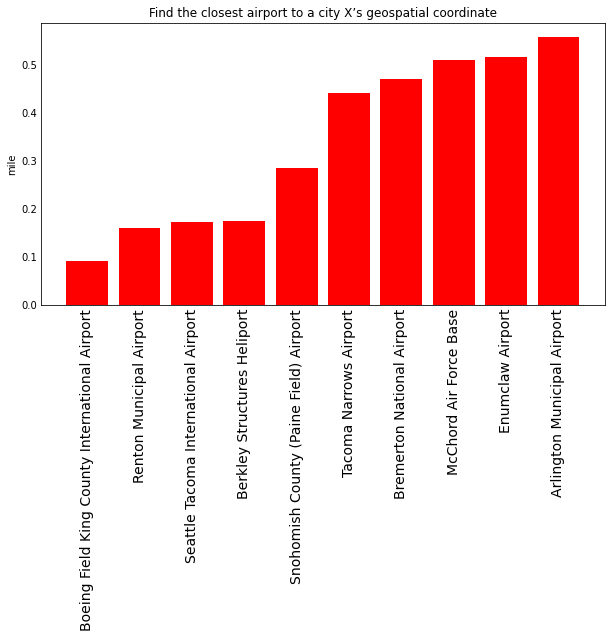

In [56]:
import matplotlib.pyplot as plt
import matplotlib
keyList = [x['Name'] for x in closestAirport.collect()]
valueList = [x['Distance'] for x in closestAirport.collect()]
x = keyList
y = valueList
plt.xticks(rotation=90, fontsize=14)
plt.bar(x,y,color='red')
plt.ylabel('mile')
plt.title('Find the closest airport to a city X’s geospatial coordinate')
plt.show()

### Line graph - closest airport to city X

<function matplotlib.pyplot.show(close=None, block=None)>

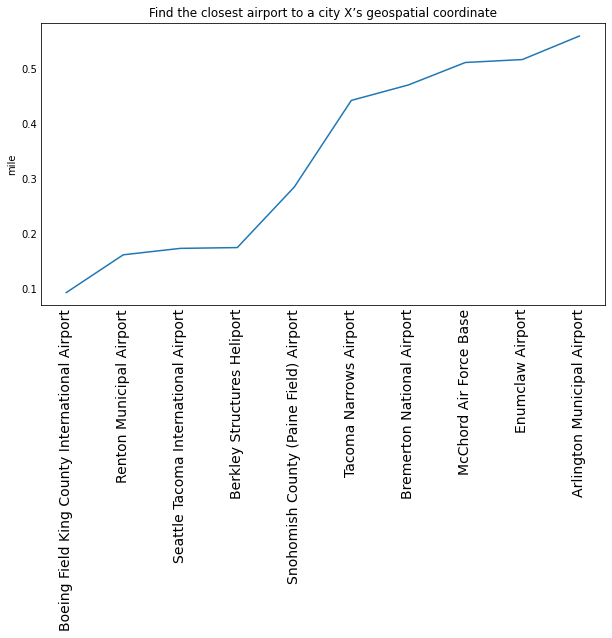

In [57]:
import matplotlib.pyplot as plt
keyList = [x['Name'] for x in closestAirport.collect()]
valueList = [x['Distance'] for x in closestAirport.collect()]
x = keyList
y = valueList
plt.xticks(rotation=90, fontsize=14)
plt.plot(x,y)
plt.ylabel('mile')
plt.title('Find the closest airport to a city X’s geospatial coordinate')
plt.show

### World Map - closest airport to city X

<AxesSubplot:>

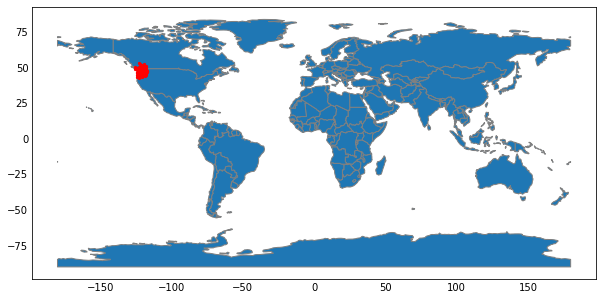

In [58]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(edgecolor='#808080')
closestAirport2.plot(ax=base, marker='o', color='red', markersize=5)

## Find the airport in each US state’s geospatial boundary 

In [63]:
# Using ST_Contains from Apache Sedona to identify which airport belongs to which states
airportInState = spark.sql("""
    select s.s_name as States, a.AirportID, a.Name, a.City, s.s_bound
    from states as s, airport as a
    where ST_Contains(s.s_bound, a.geospacial_Location)
""")

# Convert Spark dataframe into pandas dataframe
geopandas_df = gpd.GeoDataFrame(airportInState.toPandas(), geometry="s_bound")

# Show result
geopandas_df

21/12/08 17:41:41 WARN JoinQuery: UseIndex is true, but no index exists. Will build index on the fly.


,States,AirportID,Name,City,s_bound
0,Alaska,3411,Barter Island LRRS Airport,Barter Island,"POLYGON ((-141.02050 70.01870, -141.72910 70.1..."
1,Alaska,3412,Wainwright Air Station,Fort Wainwright,"POLYGON ((-141.02050 70.01870, -141.72910 70.1..."
2,Alaska,3413,Cape Lisburne LRRS Airport,Cape Lisburne,"POLYGON ((-141.02050 70.01870, -141.72910 70.1..."
3,Alaska,3414,Point Lay LRRS Airport,Point Lay,"POLYGON ((-141.02050 70.01870, -141.72910 70.1..."
4,Hawaii,3415,Hilo International Airport,Hilo,"POLYGON ((-154.62840 19.51580, -154.82350 19.8..."
...,...,...,...,...,...
1504,California,13717,Camp Pendleton MCAS (Munn Field) Airport,Oceanside,"POLYGON ((-124.40090 41.99830, -123.62370 42.0..."
1505,Georgia,13757,Vidalia Regional Airport,Vidalia,"POLYGON ((-85.60820 34.99740, -84.72660 34.990..."
1506,Texas,13758,Granbury Regional Airport,Granbury,"POLYGON ((-106.57150 31.86590, -106.50420 31.7..."
1507,New York,13759,Oswego County Airport,Fulton,"POLYGON ((-79.76240 42.51420, -79.06720 42.778..."


### Heat map - Airports per state

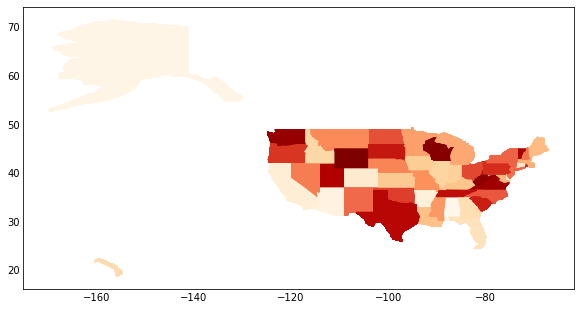

In [64]:
geopandas_df['airport_per_state'] = geopandas_df.States
geopandas_df.plot(column='airport_per_state', cmap='OrRd');